# Summer Roadtrip

**Project Description**

Generate a roadtrip route through the most picturesque and popular landmarks and natural attractions. Use available data (e.g., photo frequency, reviews) to rank stops and suggest how long to spend at each.

- Build a route display with a map and scrollable landmark cards.
- Create a visual layout highlighting landmark photos and descriptions.
- Add filtering or sorting by popularity, type (e.g., “nature,” “architecture”), or time required.
- Display total trip summary (e.g., distance, number of stops).

In [72]:
import pandas as pd
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

## Find and Prepare Data

Collect data on locations;
- Must contain longitude and latitude
- Location name
- Select a maximum of 9 locations to find the optimal route in a reasonable time
- Some datasets on Kaggle

We decided to work with 5 nationally recognizable landmarks for our sightseeing project. We manually collected the data from web searches on Google.

In [8]:
# Link to read the data in Sabrina's branch
url = 'https://raw.githubusercontent.com/KRMalaGrino/butterfly-brigade/refs/heads/sabrina/data_science/Landmark_Dataset_with_Visit_Time_and_Popularity_Factors.csv'
df = pd.read_csv(url)

In [10]:
# View the data 
df

,City,State,Landmark,Latitude,Longitude,Type,Visit Time (hrs),Average User Rating,Reviews/Photos,Annual Visitors
0,Keystone,South Dakota,Mount Rushmore,43.8791,-103.4591,Historical/Architectural,2,4.7,25000,2000000
1,Grand Canyon Village,Arizona,Grand Canyon,36.1069,-112.1129,Natural,8,4.9,60000,6000000
2,Niagara Falls,New York,Niagara Falls,43.0962,-79.0377,Natural,4,4.8,55000,9000000
3,New York,New York,Statue of Liberty,40.6892,-74.0445,Historical/Architectural,4,4.7,30000,4300000
4,St. Louis,Missouri,Gateway Arch,38.6247,-90.1848,Architectural,2,4.7,15000,2000000
5,Washington,District of Columbia,Lincoln Memorial,38.8893,-77.0502,Historical,1,4.8,25000,8000000
6,San Francisco,California,Golden Gate Bridge,37.8199,-122.4783,Architectural,2,4.8,45000,10000000
7,Orlando,Florida,Disney World,28.3852,-81.5639,Amusement Park,8,4.7,85000,58000000
8,Las Vegas,Nevada,Las Vegas Sphere,36.1699,-115.1398,Architectural/Entertainment,2,4.6,10000,3000000


In [12]:
# Reduce  list to only 5 locations and reset the index
df = df.drop(index=[1, 2, 5, 8], errors='ignore').reset_index(drop=True)

In [18]:
# Check the changes
df

,City,State,Landmark,Latitude,Longitude,Type,Visit Time (hrs),Average User Rating,Reviews/Photos,Annual Visitors
0,Keystone,South Dakota,Mount Rushmore,43.8791,-103.4591,Historical/Architectural,2,4.7,25000,2000000
1,New York,New York,Statue of Liberty,40.6892,-74.0445,Historical/Architectural,4,4.7,30000,4300000
2,St. Louis,Missouri,Gateway Arch,38.6247,-90.1848,Architectural,2,4.7,15000,2000000
3,San Francisco,California,Golden Gate Bridge,37.8199,-122.4783,Architectural,2,4.8,45000,10000000
4,Orlando,Florida,Disney World,28.3852,-81.5639,Amusement Park,8,4.7,85000,58000000


In [20]:
# Get an overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   City                 5 non-null      object 
 1   State                5 non-null      object 
 2   Landmark             5 non-null      object 
 3   Latitude             5 non-null      float64
 4   Longitude            5 non-null      float64
 5   Type                 5 non-null      object 
 6   Visit Time (hrs)     5 non-null      int64  
 7   Average User Rating  5 non-null      float64
 8   Reviews/Photos       5 non-null      int64  
 9   Annual Visitors      5 non-null      int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 532.0+ bytes


In [26]:
# Lower case the columns and fill whitespace with underscore
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('/', '_')

In [30]:
# Check changes
df.columns

Index(['city', 'state', 'landmark', 'latitude', 'longitude', 'type',
       'visit_time_(hrs)', 'average_user_rating', 'reviews_photos',
       'annual_visitors'],
      dtype='object')

In [34]:
# Lowercase the values, replace whitespace and / with an underscore
df = df.map(lambda x: x.lower().replace(' ', '_').replace('/', '_') if isinstance(x, str) else x)

In [36]:
df

,city,state,landmark,latitude,longitude,type,visit_time_(hrs),average_user_rating,reviews_photos,annual_visitors
0,keystone,south_dakota,mount_rushmore,43.8791,-103.4591,historical_architectural,2,4.7,25000,2000000
1,new_york,new_york,statue_of_liberty,40.6892,-74.0445,historical_architectural,4,4.7,30000,4300000
2,st._louis,missouri,gateway_arch,38.6247,-90.1848,architectural,2,4.7,15000,2000000
3,san_francisco,california,golden_gate_bridge,37.8199,-122.4783,architectural,2,4.8,45000,10000000
4,orlando,florida,disney_world,28.3852,-81.5639,amusement_park,8,4.7,85000,58000000


### Feature Engineering

To summarize the average_user_rating, review_photos and annual_vistors, we are creating an additional feature to score overall 'popularity' for each landmark.

In [49]:
# Set the weights to value the degree of importance of each of the columns
w_r = 0.40 # weight for the ratings
w_p = 0.30 # weight for the reviews_photos
w_v = 0.30 # weight for the visitors

In [51]:
# Calculate max values 
max_reviews = df['reviews_photos'].max()
max_visitors = df['annual_visitors'].max()

In [55]:
# Feature engineering to score popularity out of 100
df['rating_factor'] = (df['average_user_rating'] / 5) * 100
df['reviews_factor'] = (df['reviews_photos'] / max_reviews) * 100
df['visitors_factor'] = (df['annual_visitors'] / max_visitors) * 100

In [57]:
# Calculate Popularity Score
df['popularity'] = (
    (df['rating_factor'] * w_r) +
    (df['reviews_factor'] * w_p) +
    (df['visitors_factor'] * w_v)
)

In [62]:
# Check changes
df

,city,state,landmark,latitude,longitude,type,visit_time_(hrs),average_user_rating,reviews_photos,annual_visitors,rating_factor,reviews_factor,visitors_factor,popularity
0,keystone,south_dakota,mount_rushmore,43.8791,-103.4591,historical_architectural,2,4.7,25000,2000000,94.0,29.411765,3.448276,47.458012
1,new_york,new_york,statue_of_liberty,40.6892,-74.0445,historical_architectural,4,4.7,30000,4300000,94.0,35.294118,7.413793,50.412373
2,st._louis,missouri,gateway_arch,38.6247,-90.1848,architectural,2,4.7,15000,2000000,94.0,17.647059,3.448276,43.928600
3,san_francisco,california,golden_gate_bridge,37.8199,-122.4783,architectural,2,4.8,45000,10000000,96.0,52.941176,17.241379,59.454767
4,orlando,florida,disney_world,28.3852,-81.5639,amusement_park,8,4.7,85000,58000000,94.0,100.000000,100.000000,97.600000


In [68]:
# Round the 'popularity' score up to a whole number and change the type to integer
df['popularity'] = df['popularity'].round(0).astype(int)
df

,city,state,landmark,latitude,longitude,type,visit_time_(hrs),average_user_rating,reviews_photos,annual_visitors,rating_factor,reviews_factor,visitors_factor,popularity
0,keystone,south_dakota,mount_rushmore,43.8791,-103.4591,historical_architectural,2,4.7,25000,2000000,94.0,29.411765,3.448276,47
1,new_york,new_york,statue_of_liberty,40.6892,-74.0445,historical_architectural,4,4.7,30000,4300000,94.0,35.294118,7.413793,50
2,st._louis,missouri,gateway_arch,38.6247,-90.1848,architectural,2,4.7,15000,2000000,94.0,17.647059,3.448276,44
3,san_francisco,california,golden_gate_bridge,37.8199,-122.4783,architectural,2,4.8,45000,10000000,96.0,52.941176,17.241379,59
4,orlando,florida,disney_world,28.3852,-81.5639,amusement_park,8,4.7,85000,58000000,94.0,100.000000,100.000000,98


### Visualizations

**Map Route for Visiting Most Popular Destinations in Order**

This map helps visualize the route based on geography.

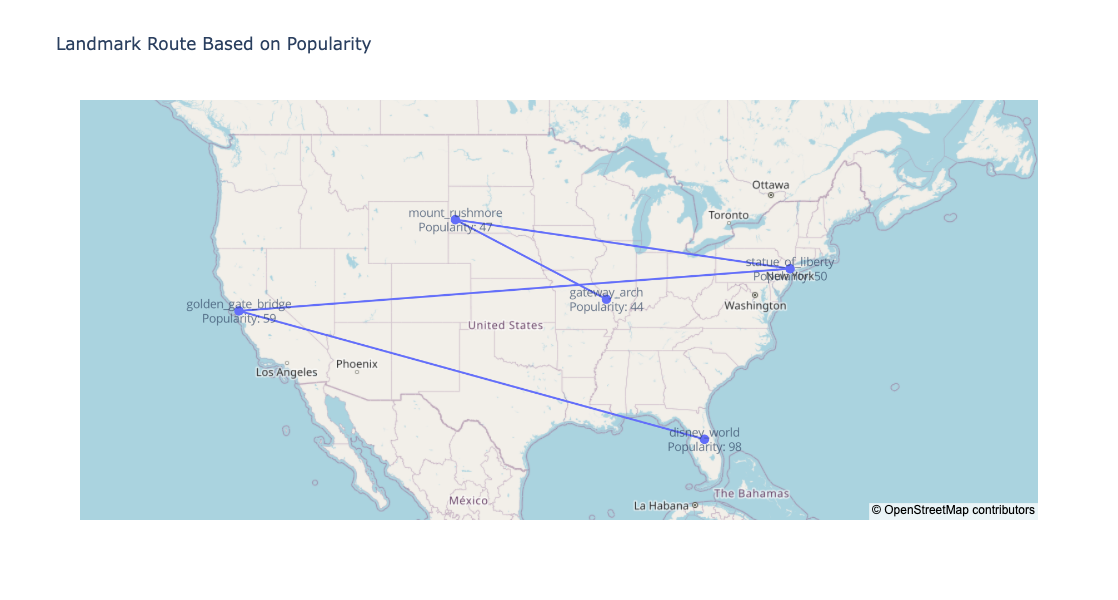

In [100]:
# Copy data 
map_df = df.copy()

# Sort based on popularity score
map_df = map_df.sort_values(by='popularity', ascending=False).reset_index(drop=True)

# Create mapbox scatter with lines
fig = go.Figure()

# Add route line to connect based off sorted popularity score
fig.add_trace(go.Scattermapbox(
    mode="lines+markers+text", # show lines, markers and text
    lon=map_df['longitude'], # longitude data
    lat=map_df['latitude'],  # latitude data
    text=map_df['landmark'] + '<br>Popularity: ' + map_df['popularity'].astype(str), # hover text
    marker={'size': 10}, # marker size for landmarks
    line={'width': 2}, # line width
    hoverinfo='text' # show text on hover only
))

# Map layout based on landmark coordinates
fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_zoom=3,
    mapbox_center={"lat": map_df['latitude'].mean(), "lon": map_df['longitude'].mean()},
    title="Landmark Route Based on Popularity",
    height=600
)

fig.show() # show the interactive map

**Top 5 Popular Landmarks**

This visualization highlights which landmarks are most popular.

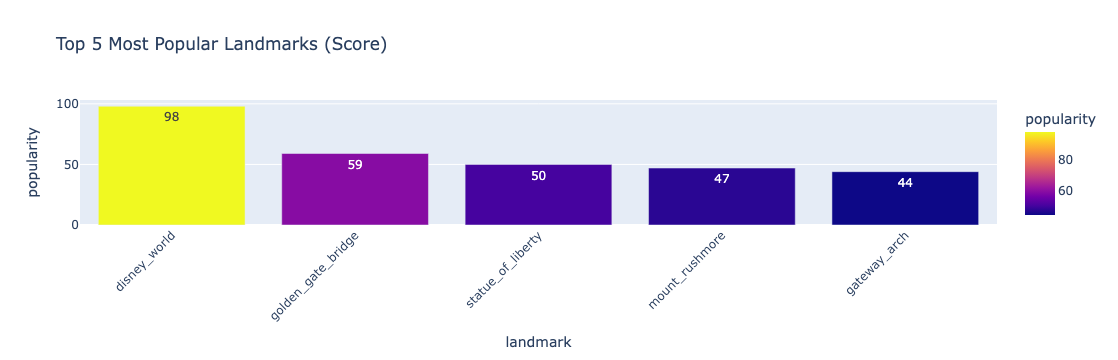

In [103]:
# Get the top 5 landmarks based on popularity score
top10 = df.sort_values(by='popularity', ascending=False).head(10)

# Create a bar chart
fig = px.bar(
    top10,
    x='landmark', # landmark names on x-axis
    y='popularity', # popularity score on y-axis
    color='popularity', # color code based on the score
    title='Top 5 Most Popular Landmarks (Score)',
    hover_data=['city', 'state', 'visit_time_(hrs)'], # show details on the hover
    text='popularity' # show scores as text on the bars
)

fig.update_layout(xaxis_tickangle=-45) # rotate text on x-axis

fig.show() # display the chart

**Visit Time Vs. Popularity**

This plot shows the trade off between visit time and popularity.

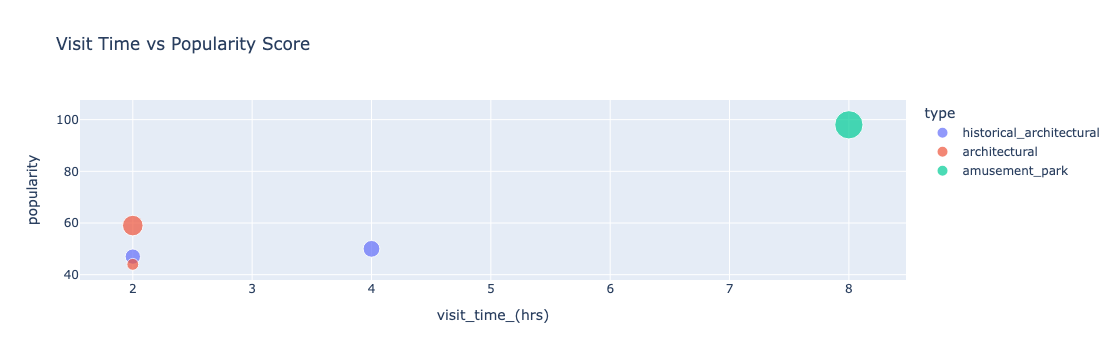

In [110]:
# Create a scatter plot to compare the relationship between visit time and popularity
fig = px.scatter(
    df,
    x='visit_time_(hrs)', # visit time on the x-axis
    y='popularity', # popularity score on the y-axis
    color='type', # color based on landmark type
    hover_name='landmark', # show landmark name on hover
    title='Visit Time vs Popularity Score', 
    size='reviews_photos', # bubble size represents number of reviews_photos
    size_max=20 # max size for the bubbles
)

fig.show()

## Modeling

First, CREATE BASELINE MODEL
-Create a first route and visualize it
-Select the next location randomly

-Each route point should be visited only once
-Compute the total distance after visiting all locations (it would allow you to evaluate the improvement of the route by your optimization model).

After your baseline model (random) is established, you need to develop an approach to optimize your route. 
- i.e., find the route with the shortest total distance.
- The total distance is the objective function, which should be minimized
- The task to find the optimal distance is a little bit different from usual ML modeling, which we talked about a lot on the platform
- To minimize the distance, you need to come up with an algorithm that selects the next location to visit in such a way that the total distance is minimized (and no location is visited twice).

After your model is created and run, please 
- Calculate the total distance for the optimized route
- Time needed to find this optimal route.
- It would be nice if both your baseline and optimized solutions were visible on the screen for comparison.

## Visualizations

The visualizations should be interactive
	- What elements will be interactive
	- How the end-user should interact with it

Visualizations you can use libraries such as plotly 
- Example: https://plotly.com/python/maps/
- More examples https://python-graph-gallery.com/
  
Visualize 
- Statistics for locations or travel times
- Include a map with locations and the optimal route on this map
- Initial and optimized total distance and time needed for the model to calculate the optimal route.

## Conclusion